Sullo stesso dataset:
* autoregressivo di primo ordine per ottenere $\bar{y}$ da $y$ e da cui calcolare il residuo $\delta$
* lineare,random forest, feed forward, per predizione di $\bar{\delta}$ per poi valutare $\bar{y} + \bar{\delta}$ con il solo $\bar{y}$
* autoregressivo di terzo ordine per la valutazione del residuo e confronto con la stessa gamma di modelli
* autoregressivo di terzo ordine fatto con random forest e confronto con la stessa gamma di modelli 
* verifica se residuo è white noise
* modello multitask

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from math import sqrt

from scipy.signal import detrend
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

sns.set(rc={'figure.figsize':(6., 3.336)})
sns.set_style("whitegrid", {'axes.grid' : False})

df = pd.read_csv('cultivable_pca.csv')
df['Date'] = pd.to_datetime(df['Date'])

features = df.iloc[:, 13:]
cols = features.columns.tolist()

In [3]:
from matplotlib.pyplot import figure

# Plotting a figure of width 6 and height 3
plt_1 = plt.figure(figsize=(15, 8))

<Figure size 1080x576 with 0 Axes>

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

In [5]:
emi2 = [18, 59, 57]
multitask = [40, 36, 25, 52, 1, 21, 35, 31, 22, 51]

ds = df[[cols[i] for i in emi2] + ['anomalia_emiliani2']]

ds['anomalia_emiliani2'] = detrend(ds['anomalia_emiliani2'])
ds['anomalia_emiliani2_t'] = ds['anomalia_emiliani2'].shift(1)
ds['anomalia_emiliani2_t-1'] = ds['anomalia_emiliani2'].shift(2)


In [6]:
columns = ds.columns.tolist()
for col in columns[:3]:
    for i in range(1,24):
        ds[col+'_t-'+str(i)] = ds[col].shift(i)
        
for col in columns[3:4]:
    for i in range(3,26):
        ds[col+'_t-'+str(i-1)] = ds[col].shift(i)
        
ds = ds.iloc[25:].reset_index(drop=True)

pcs = ds.filter(regex='PC')
anomalia = ds.filter(regex='emiliani2_t')
ds = ds[pcs.columns.tolist() + anomalia.columns.tolist()[1:] + anomalia.columns.tolist()[0:1]]

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [8]:
# divide into train/test
train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

scaler = StandardScaler()
scaler.fit(train)
ds[ds.columns] = scaler.transform(ds[ds.columns])

In [9]:
train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

In [10]:
def feed_forward():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='mse',
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  
  return model

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Modello autoregressivo del primo ordine

In [12]:
auto_reg1_val = LinearRegression()
auto_reg1 = LinearRegression()

train_val = pd.concat([train,validation])

auto_reg1_val.fit(train.iloc[:, 72].values.reshape(-1,1), train.iloc[:, -1].values)
auto_reg1.fit(train_val.iloc[int(len(train_val)*0.2):, 72].values.reshape(-1,1), train_val.iloc[int(len(train_val)*0.2):, -1].values)

LinearRegression()

Residuo su train set

In [13]:
y_hat_val = auto_reg1_val.predict(train.iloc[:, 72].values.reshape(-1,1))
residual_val = train.iloc[:, -1].values - y_hat_val

In [14]:
frame = train.iloc[:, :72] # serie storica di variabili
frame['residual'] = residual_val

In [15]:
linear_val = LinearRegression()
linear_val.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values)

LinearRegression()

In [16]:
from hypopt import GridSearch

ext = ExtraTreesRegressor()

opt = GridSearch(model = ext, param_grid = random_grid)

opt.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values, validation.iloc[:, :72].values, validation.iloc[:, -1].values)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
ffnn_val = feed_forward()
hist_val = ffnn_val.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values, shuffle=False, epochs=100, validation_data=(validation.iloc[:, :72].values, validation.iloc[:, -1].values), callbacks=callback)

100%|██████████| 480/480 [00:37<00:00, 12.80it/s]


Epoch 1/100
19/19 [==============================] - 1s 22ms/step - loss: 0.4943 - mean_absolute_error: 0.5171 - val_loss: 0.8692 - val_mean_absolute_error: 0.7886
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.4459 - mean_absolute_error: 0.4673 - val_loss: 0.7894 - val_mean_absolute_error: 0.7430
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.2375 - mean_absolute_error: 0.3358 - val_loss: 0.7436 - val_mean_absolute_error: 0.6987
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.2054 - mean_absolute_error: 0.3044 - val_loss: 0.6953 - val_mean_absolute_error: 0.6632
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1911 - mean_absolute_error: 0.2848 - val_loss: 0.6876 - val_mean_absolute_error: 0.6575
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1836 - mean_absolute_error: 0.2782 - val_loss: 0.6842 - val_mean_absolute_error: 0.6534
Epoch 7/100
19/19 [==

In [17]:
opt.best_estimator_

ExtraTreesRegressor(bootstrap=True, max_depth=10, max_features='sqrt',
                    min_samples_leaf=2, n_estimators=400, random_state=0)

In [75]:
autoreg_mae = mean_absolute_error(train.iloc[:, -1].values, y_hat_val)
linear_mae = mean_absolute_error(train.iloc[:, -1].values, linear_val.predict(frame.iloc[:, :-1].values) + y_hat_val)
rf_mae = mean_absolute_error(train.iloc[:, -1].values, opt.predict(frame.iloc[:, :-1].values) + y_hat_val)
ffnn_mae = mean_absolute_error(train.iloc[:, -1].values, ffnn_val.predict(frame.iloc[:, :-1].values).flatten() + y_hat_val)

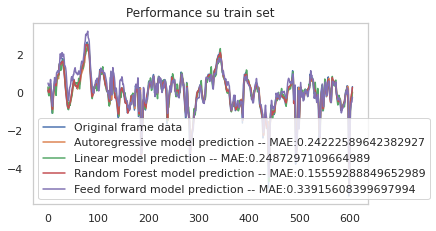

In [76]:
plt.title("Performance su train set")

plt.plot(train.iloc[:, -1].values, label='Original frame data')
plt.plot(y_hat_val, label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(frame.iloc[:, :-1].values) + y_hat_val, label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(frame.iloc[:, :-1].values) + y_hat_val, label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(frame.iloc[:, :-1].values).flatten() + y_hat_val, label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

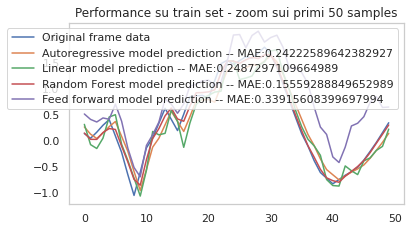

In [77]:
plt.title("Performance su train set - zoom sui primi 50 samples")

plt.plot(train.iloc[:50, -1].values, label='Original frame data')
plt.plot(y_hat_val[:50], label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(frame.iloc[:, :-1].values)[:50] + y_hat_val[:50], label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(frame.iloc[:, :-1].values)[:50] + y_hat_val[:50], label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(frame.iloc[:, :-1].values).flatten()[:50] + y_hat_val[:50], label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

In [78]:
autoreg_y = auto_reg1_val.predict(validation.iloc[:, 72].values.reshape(-1,1))
autoreg_mae = mean_absolute_error(validation.iloc[:, -1].values, autoreg_y)
linear_mae = mean_absolute_error(validation.iloc[:, -1].values, linear_val.predict(validation.iloc[:, :72].values) + autoreg_y)
rf_mae = mean_absolute_error(validation.iloc[:, -1].values, opt.predict(validation.iloc[:, :72].values) + autoreg_y)
ffnn_mae = mean_absolute_error(validation.iloc[:, -1].values, ffnn_val.predict(validation.iloc[:, :72].values).flatten() + autoreg_y)

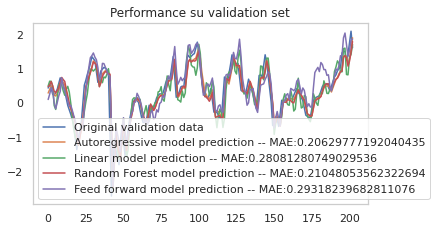

In [79]:
plt.title("Performance su validation set")

plt.plot(validation.iloc[:, -1].values, label='Original validation data')
plt.plot(autoreg_y, label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(validation.iloc[:, :72].values) + autoreg_y, label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(validation.iloc[:, :72].values) + autoreg_y, label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(validation.iloc[:, :72].values).flatten() + autoreg_y, label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

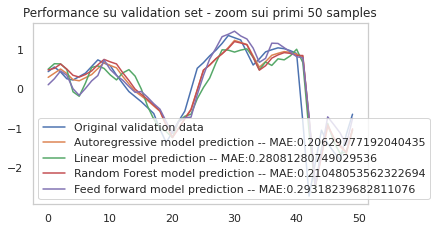

In [80]:
plt.title("Performance su validation set - zoom sui primi 50 samples")

plt.plot(validation.iloc[:50, -1].values, label='Original validation data')
plt.plot(autoreg_y[:50], label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(validation.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(validation.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(validation.iloc[:, :72].values).flatten()[:50] + autoreg_y[:50], label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

Residuo su test test

In [81]:
y_hat = auto_reg1.predict(train_val.iloc[int(len(train_val)*0.2):, 72].values.reshape(-1,1))
residual = train_val.iloc[int(len(train_val)*0.2):, -1].values - y_hat

In [82]:
frame = train_val.iloc[int(len(train_val)*0.2):,  :72] # serie storica di variabili
frame['residual'] = residual

linear_val = LinearRegression()
linear_val.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values)

LinearRegression()

In [83]:
best_rf = opt.best_estimator_

best_rf.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values)

ffnn = feed_forward()
hist = ffnn.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values, shuffle=False, epochs=50)

Epoch 1/50
21/21 [==============================] - 0s 2ms/step - loss: 1.0441 - mean_absolute_error: 0.8102
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3236 - mean_absolute_error: 0.4218
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2270 - mean_absolute_error: 0.3301
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2051 - mean_absolute_error: 0.3030
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1995 - mean_absolute_error: 0.2969
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1939 - mean_absolute_error: 0.2876
Epoch 7/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1908 - mean_absolute_error: 0.2858
Epoch 8/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1891 - mean_absolute_error: 0.2822
Epoch 9/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1877 - mean_absolute_error: 0.2818
Epoch 10/50
21/21 [

In [84]:
autoreg_y = auto_reg1.predict(test.iloc[:, 72].values.reshape(-1,1))
autoreg_mae = mean_absolute_error(test.iloc[:, -1].values, autoreg_y)
linear_mae = mean_absolute_error(test.iloc[:, -1].values, linear_val.predict(test.iloc[:, :72].values) + autoreg_y)
rf_mae = mean_absolute_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :72].values) + autoreg_y)
ffnn_mae = mean_absolute_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :72].values).flatten() + autoreg_y)

In [85]:
 autoreg_mae,  linear_mae,  rf_mae,  ffnn_mae

(0.16023820748153172,
 0.2061123229991045,
 0.17227536900344648,
 0.22879387990411554)

In [86]:
autoreg_mse = mean_squared_error(test.iloc[:, -1].values, autoreg_y)
linear_mse = mean_squared_error(test.iloc[:, -1].values, linear_val.predict(test.iloc[:, :72].values) + autoreg_y)
rf_mse = mean_squared_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :72].values) + autoreg_y)
ffnn_mse = mean_squared_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :72].values).flatten() + autoreg_y)

In [87]:
 autoreg_mse,  linear_mse,  rf_mse,  ffnn_mse

(0.04061750321956284,
 0.06997516833753581,
 0.04720018576964141,
 0.08581647714150752)

In [88]:
sqrt(autoreg_mse), sqrt(linear_mse), sqrt(rf_mse), sqrt(ffnn_mse)

(0.2015378456259837,
 0.26452819951289847,
 0.2172560373606253,
 0.29294449498413094)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


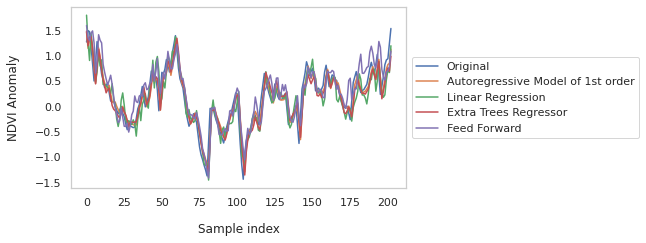

In [89]:
#plt.title("Performance su test set")

plt.plot(test.iloc[:, -1].values, label='Original')
plt.plot(autoreg_y, label='Autoregressive Model of 1st order')
plt.plot(linear_val.predict(test.iloc[:, :72].values) + autoreg_y, label='Linear Regression')
plt.plot(best_rf.predict(test.iloc[:, :72].values) + autoreg_y, label='Extra Trees Regressor')
plt.plot(ffnn.predict(test.iloc[:, :72].values).flatten() + autoreg_y, label='Feed Forward')
plt.xlabel('Sample index',labelpad=15)
plt.ylabel('NDVI Anomaly',labelpad=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('imgs/residual_1ordine.eps', format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


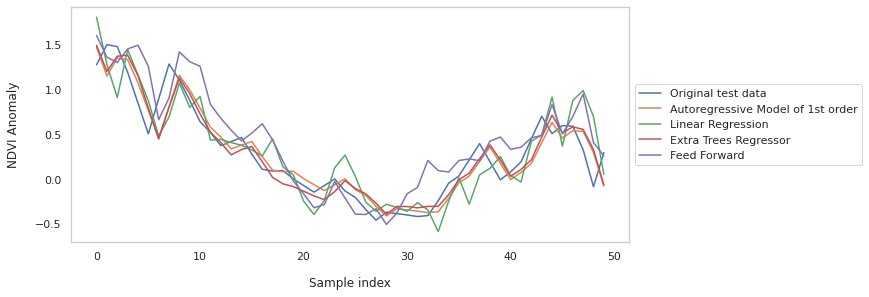

In [90]:
#plt.title("Performance su test set -- zoom sui primi 50 samples")
sns.set(rc={'figure.figsize':(10., 4.336)})
sns.set_style("whitegrid", {'axes.grid' : False})
plt.plot(test.iloc[:50, -1].values, label='Original test data')
plt.plot(autoreg_y[:50], label='Autoregressive Model of 1st order')
plt.plot(linear_val.predict(test.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Linear Regression')
plt.plot(best_rf.predict(test.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Extra Trees Regressor')
plt.plot(ffnn.predict(test.iloc[:, :72].values).flatten()[:50] + autoreg_y[:50], label='Feed Forward')
plt.xlabel('Sample index',labelpad=15)
plt.ylabel('NDVI Anomaly',labelpad=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('imgs/residual_1ordine_zoom.eps', format='eps', bbox_inches='tight')
plt.show()

### White noise test

,lb_stat,lb_pvalue
50,152.363888,2.799367e-12


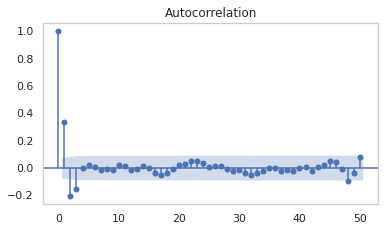

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox as acl

plot_acf(residual, lags=50)
autocorr = acl(residual, lags=[50], boxpierce=False, model_df=0, period=None, return_df=True)
autocorr

# Modelli autoregressivi di ordine superiore al primo

## Modello lineare autoregressivo

In [18]:
auto_reg3_val = LinearRegression()
auto_reg3 = LinearRegression()

train_val = pd.concat([train,validation])

auto_reg3_val.fit(train.iloc[:, [72,73,74]].values, train.iloc[:, -1].values)
auto_reg3.fit(train_val.iloc[int(len(train_val)*0.2):, [72,73,74]].values, train_val.iloc[int(len(train_val)*0.2):, -1].values)

# residuo su train set

y_hat_val = auto_reg3_val.predict(train.iloc[:, [72,73,74]].values)
residual_val = train.iloc[:, -1].values - y_hat_val

frame = train.iloc[:, :72] # serie storica di variabili
frame['residual'] = residual_val

linear_val = LinearRegression()
linear_val.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values)


ext = ExtraTreesRegressor()

opt = GridSearch(model = ext, param_grid = random_grid)

opt.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values, validation.iloc[:, :72].values, validation.iloc[:, -1].values)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
ffnn_val = feed_forward()
hist_val = ffnn_val.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values, shuffle=False, epochs=100, validation_data=(validation.iloc[:, :72].values, validation.iloc[:, -1].values), callbacks=callback)

autoreg_mae = mean_absolute_error(train.iloc[:, -1].values, y_hat_val)
linear_mae = mean_absolute_error(train.iloc[:, -1].values, linear_val.predict(frame.iloc[:, :-1].values) + y_hat_val)
rf_mae = mean_absolute_error(train.iloc[:, -1].values, opt.predict(frame.iloc[:, :-1].values) + y_hat_val)
ffnn_mae = mean_absolute_error(train.iloc[:, -1].values, ffnn_val.predict(frame.iloc[:, :-1].values).flatten() + y_hat_val)

100%|██████████| 480/480 [00:45<00:00, 10.66it/s]


Epoch 1/100
19/19 [==============================] - 1s 16ms/step - loss: 0.7556 - mean_absolute_error: 0.6642 - val_loss: 0.8129 - val_mean_absolute_error: 0.7506
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.4225 - mean_absolute_error: 0.4603 - val_loss: 0.6889 - val_mean_absolute_error: 0.6514
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.2544 - mean_absolute_error: 0.3677 - val_loss: 0.7513 - val_mean_absolute_error: 0.7088
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.2144 - mean_absolute_error: 0.3215 - val_loss: 0.7838 - val_mean_absolute_error: 0.7326
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1952 - mean_absolute_error: 0.2990 - val_loss: 0.8019 - val_mean_absolute_error: 0.7437
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1862 - mean_absolute_error: 0.2875 - val_loss: 0.7999 - val_mean_absolute_error: 0.7420
Epoch 7/100
19/19 [==

In [19]:
opt.best_estimator_

ExtraTreesRegressor(bootstrap=True, max_depth=10, max_features='sqrt',
                    min_samples_leaf=2, min_samples_split=5, n_estimators=400,
                    random_state=0)

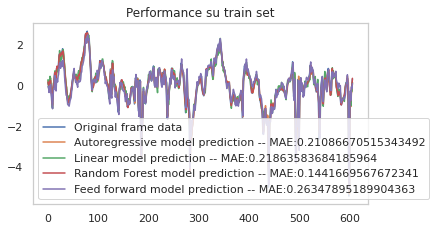

In [35]:
plt.title("Performance su train set")

plt.plot(train.iloc[:, -1].values, label='Original frame data')
plt.plot(y_hat_val, label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(frame.iloc[:, :-1].values) + y_hat_val, label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(frame.iloc[:, :-1].values) + y_hat_val, label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(frame.iloc[:, :-1].values).flatten() + y_hat_val, label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

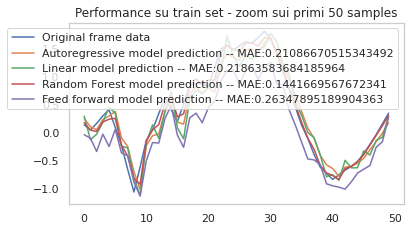

In [36]:
plt.title("Performance su train set - zoom sui primi 50 samples")

plt.plot(train.iloc[:50, -1].values, label='Original frame data')
plt.plot(y_hat_val[:50], label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(frame.iloc[:, :-1].values)[:50] + y_hat_val[:50], label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(frame.iloc[:, :-1].values)[:50] + y_hat_val[:50], label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(frame.iloc[:, :-1].values).flatten()[:50] + y_hat_val[:50], label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

In [37]:
autoreg_y = auto_reg3_val.predict(validation.iloc[:, [72,73,74]].values)
autoreg_mae = mean_absolute_error(validation.iloc[:, -1].values, autoreg_y)
linear_mae = mean_absolute_error(validation.iloc[:, -1].values, linear_val.predict(validation.iloc[:, :72].values) + autoreg_y)
rf_mae = mean_absolute_error(validation.iloc[:, -1].values, opt.predict(validation.iloc[:, :72].values) + autoreg_y)
ffnn_mae = mean_absolute_error(validation.iloc[:, -1].values, ffnn_val.predict(validation.iloc[:, :72].values).flatten() + autoreg_y)

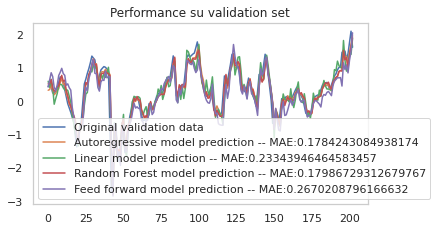

In [38]:
plt.title("Performance su validation set")

plt.plot(validation.iloc[:, -1].values, label='Original validation data')
plt.plot(autoreg_y, label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(validation.iloc[:, :72].values) + autoreg_y, label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(validation.iloc[:, :72].values) + autoreg_y, label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(validation.iloc[:, :72].values).flatten() + autoreg_y, label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

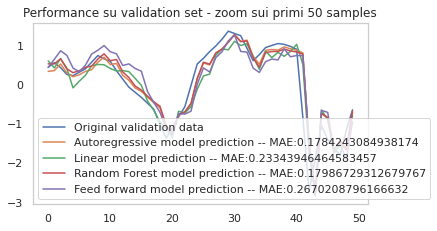

In [39]:
plt.title("Performance su validation set - zoom sui primi 50 samples")

plt.plot(validation.iloc[:50, -1].values, label='Original validation data')
plt.plot(autoreg_y[:50], label='Autoregressive model prediction -- MAE:' + str(autoreg_mae))
plt.plot(linear_val.predict(validation.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(validation.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(validation.iloc[:, :72].values).flatten()[:50] + autoreg_y[:50], label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

Residuo su test test

In [40]:
y_hat = auto_reg3.predict(train_val.iloc[int(len(train_val)*0.2):, [72,73,74]].values)
residual = train_val.iloc[int(len(train_val)*0.2):, -1].values - y_hat

In [41]:
frame = train_val.iloc[int(len(train_val)*0.2):,  :72] # serie storica di variabili
frame['residual'] = residual

linear_val = LinearRegression()
linear_val.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values)

LinearRegression()

In [42]:
best_rf = opt.best_estimator_

best_rf.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values)

ffnn = feed_forward()
hist = ffnn.fit(frame.iloc[:, :-1].values, frame.iloc[:, -1].values, shuffle=False, epochs=50)

Epoch 1/50
21/21 [==============================] - 0s 2ms/step - loss: 0.7791 - mean_absolute_error: 0.7304
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3203 - mean_absolute_error: 0.4361
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2078 - mean_absolute_error: 0.3287
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1781 - mean_absolute_error: 0.2837
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1682 - mean_absolute_error: 0.2686
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1634 - mean_absolute_error: 0.2606
Epoch 7/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1585 - mean_absolute_error: 0.2543
Epoch 8/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1556 - mean_absolute_error: 0.2499
Epoch 9/50
21/21 [==============================] - 0s 2ms/step - loss: 0.1515 - mean_absolute_error: 0.2450
Epoch 10/50
21/21 [

In [43]:
autoreg_y = auto_reg3.predict(test.iloc[:, [72,73,74]].values)
autoreg_mae = mean_absolute_error(test.iloc[:, -1].values, autoreg_y)
linear_mae = mean_absolute_error(test.iloc[:, -1].values, linear_val.predict(test.iloc[:, :72].values) + autoreg_y)
rf_mae = mean_absolute_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :72].values) + autoreg_y)
ffnn_mae = mean_absolute_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :72].values).flatten() + autoreg_y)

In [46]:
autoreg_mae, linear_mae, rf_mae, ffnn_mae

(0.1334251620231746,
 0.17350487972258052,
 0.1416818538788726,
 0.20408938689979123)

In [45]:
autoreg_mse = mean_squared_error(test.iloc[:, -1].values, autoreg_y)
linear_mse = mean_squared_error(test.iloc[:, -1].values, linear_val.predict(test.iloc[:, :72].values) + autoreg_y)
rf_mse = mean_squared_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :72].values) + autoreg_y)
ffnn_mse = mean_squared_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :72].values).flatten() + autoreg_y)

In [47]:
autoreg_mse, linear_mse, rf_mse, ffnn_mse

(0.02948046575657747,
 0.052037033475731374,
 0.033363934481385166,
 0.07051128050626648)

In [48]:
sqrt(autoreg_mse), sqrt(linear_mse), sqrt(rf_mse), sqrt(ffnn_mse)

(0.17169876457498892,
 0.22811627183463123,
 0.18265797130534753,
 0.26553960251959874)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


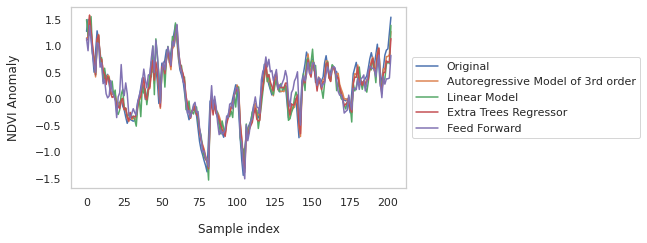

In [49]:
#plt.title("Performance su test set")

plt.plot(test.iloc[:, -1].values, label='Original')
plt.plot(autoreg_y, label='Autoregressive Model of 3rd order')
plt.plot(linear_val.predict(test.iloc[:, :72].values) + autoreg_y, label='Linear Model')
plt.plot(best_rf.predict(test.iloc[:, :72].values) + autoreg_y, label='Extra Trees Regressor')
plt.plot(ffnn.predict(test.iloc[:, :72].values).flatten() + autoreg_y, label='Feed Forward ')
plt.xlabel('Sample index',labelpad=15)
plt.ylabel('NDVI Anomaly',labelpad=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('imgs/residual_3ordine.eps', format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


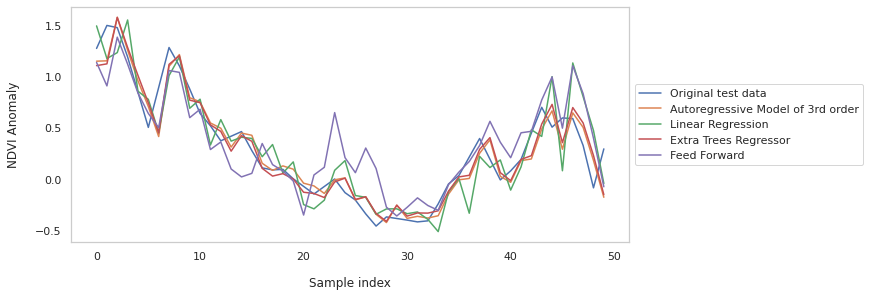

In [58]:
#plt.title("Performance su test set -- zoom sui primi 50 samples")

sns.set(rc={'figure.figsize':(10., 4.336)})
sns.set_style("whitegrid", {'axes.grid' : False})
plt.plot(test.iloc[:50, -1].values, label='Original test data')
plt.plot(autoreg_y[:50], label='Autoregressive Model of 3rd order')
plt.plot(linear_val.predict(test.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Linear Regression')
plt.plot(best_rf.predict(test.iloc[:, :72].values)[:50] + autoreg_y[:50], label='Extra Trees Regressor')
plt.plot(ffnn.predict(test.iloc[:, :72].values).flatten()[:50] + autoreg_y[:50], label='Feed Forward')
plt.xlabel('Sample index',labelpad=15)
plt.ylabel('NDVI Anomaly',labelpad=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('imgs/residual_3ordine_zoom.eps', format='eps', bbox_inches='tight')
plt.show()

(array([36.847184]), array([0.91682836]))

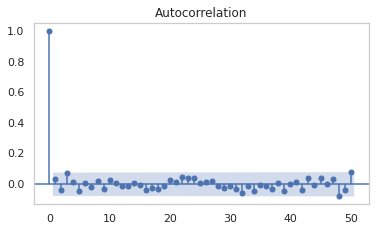

In [46]:
plot_acf(residual, lags=50)
acl(residual, lags=[50], boxpierce=False, model_df=0, period=None, return_df=True)